# Figure 5: Failure modes of C2ST



In [1]:
import torch
from torch import ones, zeros, float32, as_tensor, tensor, eye, sum, Tensor, manual_seed
from torch.distributions import MultivariateNormal, Normal
from typing import Any
import matplotlib as mpl
import seaborn as sns
import numpy as np
from sklearn.neural_network import MLPClassifier

import time
import IPython.display as IPd
from svgutils.compose import *

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
from labproject.metrics.c2st import c2st_optimal, c2st_nn, c2st_knn, c2st_rf, c2st_scores
from labproject.data import toy_mog_2d

## Visualize data and fit

In [3]:
# seed for reproducibility
_ = torch.manual_seed(0)
_ = np.random.seed(0)

In [4]:
# sample from mog
data = toy_mog_2d()
data_samples = data.sample((10_000,))

In [5]:
# make gaussian approx
mean = torch.mean(data_samples, dim=0)
cov = torch.cov(data_samples.T)
gen_model = MultivariateNormal(mean, cov)

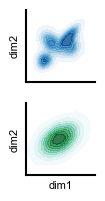

In [14]:
# plot density

_ = torch.manual_seed(0)

with mpl.rc_context(fname="matplotlibrc"):
    n_samples = 10000
    samples_mog = data_samples
    samples_np = samples_mog.numpy()
    samples_normal_approx = gen_model.sample((100_000,)).numpy()

    n_plot = 10
    samples_to_plot = samples_np[0:10,:]

    al=0.8
    ms=8
    mec='k'

    densities = [samples_np, samples_normal_approx]
    cmaps = ['Blues', 'BuGn']

    fig, axs = plt.subplots(2, 1, figsize=(0.9, 2.15))
    for i_a, ax in enumerate(axs):
        density, cmap = densities[i_a], cmaps[i_a]
        sns.kdeplot(x=density[:,0], y=density[:,1], fill=True, thresh=0.05, levels=10, cmap=cmap, ax=ax, alpha=al)
        ax.set_xticks([]); ax.set_yticks([])

        ax.set_xlim([-7,4]); ax.set_ylim([-6,4])

    axs[1].set_xlabel('dim1')
    axs[0].set_ylabel('dim2')
    axs[1].set_ylabel('dim2')

    plt.subplots_adjust(hspace=0.3)

    plt.savefig("svg/fig2_illustration.svg", bbox_inches="tight", transparent=True)
    plt.show()

## Too few samples

In [9]:
# get true c2st
c2st_gt = c2st_optimal(data, gen_model)

In [10]:
# set sample sizes
budgets = [10, 100, 1000, 10_000]

In [11]:
# compute c2sts for all sample sizes
estimates = []
for budget in budgets:
    _ = torch.manual_seed(0)
    estimates.append(c2st_nn(data.sample((budget,)), gen_model.sample((budget,)), seed=0).item())

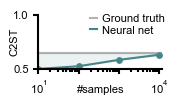

In [15]:
# plot curve

good_vals = [c2st_gt for _ in range(len(budgets))]

with mpl.rc_context(fname="matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.6, 0.7))
    _ = ax.axhline(c2st_gt, color="gray", alpha=0.6)
    _ = ax.plot(budgets, estimates, c="#458588")
    _ = ax.scatter(budgets, estimates, c="#458588", s=15.0)
    _ = ax.fill_between(budgets, good_vals, estimates, color="#458588", alpha=0.1)
    _ = ax.set_ylim([0.5, 1.0])
    _ = ax.set_xlim([10, 12200])
    _ = ax.legend(["Ground truth", "Neural net"], handlelength=0.7, handletextpad=0.4, labelspacing=0.1, loc="upper right", bbox_to_anchor=[1.1, 1.2, 0.0, 0.0])
    _ = ax.set_ylabel("C2ST", labelpad=-5)
    _ = ax.set_xscale("log")
    _ = ax.set_xticks(budgets)
    _ = ax.set_xticklabels([r"$10^1$", "", "", r"$10^4$"])
    _ = ax.set_yticks([0.5, 1.0])
    _ = ax.set_xlabel("#samples", labelpad=-8.0)

    locmin = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0, 1.0, 0.1),numticks=12)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    plt.savefig("svg/fig2_panel_a.svg", bbox_inches="tight", transparent=True)
    plt.show()

## A too poor classifier

In [16]:
# create bad c2st metric with control of hidden layer size

def poor_c2st(
    X: Tensor,
    Y: Tensor,
    seed: int = 1,
    n_folds: int = 5,
    metric: str = "accuracy",
    hidden_size: int = 5,
    clf_kwargs: dict[str, Any] = {}
):
    clf_class = MLPClassifier
    ndim = X.shape[-1]
    defaults = {
        "activation": "relu",
        "hidden_layer_sizes": (hidden_size * ndim),
        "max_iter": 1000,
        "solver": "adam",
        "early_stopping": True,
        "n_iter_no_change": 50,
    }
    defaults.update(clf_kwargs)

    scores_ = c2st_scores(
        X,
        Y,
        seed=seed,
        n_folds=n_folds,
        metric=metric,
        z_score=True,
        noise_scale=None,
        verbosity=0,
        clf_class=clf_class,
        clf_kwargs=defaults,
    )

    scores = np.mean(scores_).astype(np.float32)
    value = torch.from_numpy(np.atleast_1d(scores))
    return value

In [17]:
# compute c2st with various neural net hidden sizes

budget = 10_000

hidden_sizes = [1, 2, 4, 8, 16]
poors = []
for hidden_size in hidden_sizes:
    _ = torch.manual_seed(1)
    poors.append(poor_c2st(data.sample((budget,)), gen_model.sample((budget,)), hidden_size=hidden_size, seed=1).item())

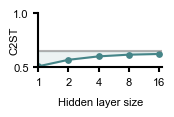

In [18]:
# plot curve

good_vals = [c2st_gt for _ in range(len(hidden_sizes))]

with mpl.rc_context(fname="matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.6, 0.7))
    _ = ax.axhline(c2st_gt, color="gray", alpha=0.6)
    _ = ax.plot(hidden_sizes, poors, c="#458588")
    _ = ax.scatter(hidden_sizes, poors, c="#458588", s=15.0)
    _ = ax.fill_between(hidden_sizes, good_vals, poors, color="#458588", alpha=0.1)
    _ = ax.set_ylim([0.5, 1.0])
    _ = ax.set_ylabel("C2ST", labelpad=-5)
    _ = ax.set_xscale("log")

    _ = ax.set_xticks([1, 2, 4, 8, 16])
    _ = ax.set_xticklabels(["1", "2", "4", "8", "16"])
    _ = ax.minorticks_off()
    _ = ax.set_xlim([1, 17.4])
    _ = ax.set_yticks([0.5, 1.0])
    _ = ax.set_xlabel("Hidden layer size", labelpad=7.4)
    plt.savefig("svg/fig2_panel_b.svg", bbox_inches="tight", transparent=True)
    plt.show()

## High-D Gaussian behavior

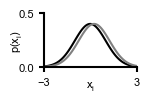

In [19]:
# visualize marginal densities

with mpl.rc_context(fname="matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.2, 0.7))
    x = np.linspace(-3, 3, 100)
    gaussian = lambda x, mu=0.0: np.exp(-0.5 * (x - mu) ** 2) / np.sqrt(2 * np.pi)
    _ = ax.plot(x, gaussian(x), label=r'$\mathcal{N}(0, 1)$', c="k")
    _ = ax.plot(x, gaussian(x, 0.25), label='$\mathcal{N}(0.25, 1)$', c="gray")
    _ = ax.set_xlabel(r"$x_i$", labelpad=-5)
    _ = ax.set_ylabel(r"$p(x_i)$", labelpad=-5)
    _ = ax.set_ylim([0, 0.5])
    _ = ax.set_yticks([0, 0.5])
    _ = ax.set_xlim([-3, 3])
    _ = ax.set_xticks([-3, 3])
    plt.savefig("svg/fig2_panel_c1.svg", bbox_inches="tight", transparent=True)
    plt.show()

In [20]:
# compute true c2sts across dimensionalities

import pandas as pd

df = []
for dim in [1, 2, 4, 8, 16, 32, 64, 128]:
    print(dim, time.ctime())
    true = MultivariateNormal(0.0 * ones(dim), eye(dim))
    model = MultivariateNormal(0.25 * ones(dim), eye(dim))

    c2st_optimal_score = c2st_optimal(true, model, 100_000)

    df.append(dict(
        dim=dim,
        c2st_optimal_score=c2st_optimal_score.item(),
    ))
df = pd.DataFrame(df)

1 Wed Mar  6 15:06:45 2024
2 Wed Mar  6 15:06:45 2024
4 Wed Mar  6 15:06:45 2024
8 Wed Mar  6 15:06:45 2024
16 Wed Mar  6 15:06:45 2024
32 Wed Mar  6 15:06:45 2024
64 Wed Mar  6 15:06:45 2024
128 Wed Mar  6 15:06:46 2024


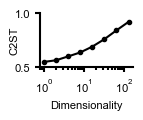

In [21]:
# plot curve

with mpl.rc_context(fname="matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.2, 0.7))
    _ = ax.plot(df['dim'], df['c2st_optimal_score'], label='gt', color='k')
    _ = ax.scatter(df['dim'], df['c2st_optimal_score'], label='gt', color='k')

    _ = ax.set_xlabel(r"Dimensionality")
    _ = ax.set_ylabel("C2ST", labelpad=-4)
    _ = ax.set_xscale('log')
    _ = ax.set_ylim([0.5, 1.0])
    _ = ax.set_yticks([0.5, 1.0])

    plt.savefig("svg/fig2_panel_c2.svg", bbox_inches="tight", transparent=True)
    plt.show()

## MNIST behavior

In [22]:
# download mnist

mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [23]:
# preprocess data

X = mnist.data.astype('float32')
X /= 255.0
y = mnist.target.astype('int64')

In [24]:
# restrict to ones

mask = (y == 1)
X = X[mask]
y = y[mask]

In [25]:
# fit 20-component gmm

_ = torch.manual_seed(1)
_ = np.random.seed(1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
gmm = GaussianMixture(
    n_components=20,
    random_state=1,
)
gmm.fit(X_train)

GaussianMixture(n_components=20, random_state=1)

In [26]:
# sample from gmm

gmm_samples = gmm.sample(10_000)[0]

In [27]:
# save for later use

with open("many_gmm_samples.pkl", "wb") as handle:
    pickle.dump(gmm_samples, handle)

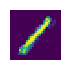

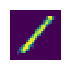

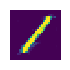

In [36]:
# visualize gmm samples

with mpl.rc_context(fname="matplotlibrc"):
    for i in range(3):
        fig, ax = plt.subplots(1, 1, figsize=(0.65, 0.65))
        _ = ax.imshow(gmm_samples[i].reshape(28, 28), clim=[0, 1])
        _ = ax.spines["bottom"].set_visible(False)
        _ = ax.spines["left"].set_visible(False)
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])
        plt.savefig(f"svg/fig2_gmm_mnist_{i}.svg", bbox_inches="tight")
        plt.show()

In [29]:
# make single gaussian approximation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
cov = torch.cov(torch.as_tensor(X_train.T))
cov += torch.eye(len(cov)) * 1e-6
mean = torch.mean(torch.as_tensor(X_train), dim=0)
gaussian_fit = MultivariateNormal(mean, cov)

gaussian_samples = gaussian_fit.sample((100,))

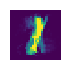

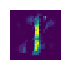

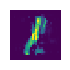

In [30]:
# visualize single gaussian samples

with mpl.rc_context(fname="matplotlibrc"):
    for i in range(3):
        fig, ax = plt.subplots(1, 1, figsize=(0.65, 0.65))
        _ = ax.imshow(gaussian_samples[i].reshape(28, 28), clim=[0, 1])
        _ = ax.spines["bottom"].set_visible(False)
        _ = ax.spines["left"].set_visible(False)
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])
        plt.savefig(f"svg/fig2_gauss_mnist_{i}.svg", bbox_inches="tight")
        plt.show()

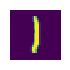

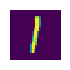

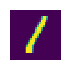

In [31]:
# visualize true digits

with mpl.rc_context(fname="matplotlibrc"):
    for i in range(3):
        fig, ax = plt.subplots(1, 1, figsize=(0.65, 0.65))
        _ = ax.imshow(X_train[i].reshape(28, 28), clim=[0, 1])
        _ = ax.spines["bottom"].set_visible(False)
        _ = ax.spines["left"].set_visible(False)
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])
        plt.savefig(f"svg/fig2_mnist_{i}.svg", bbox_inches="tight")
        plt.show()

## Compose figure

In [37]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_caption = {'size': '10pt', 'font': 'Arial', 'weight': '800'}
kwargs_text = {'size': '7.75pt', 'font': 'Arial'}

f = Figure(
    "16.6cm",
    "5.6cm",
    Panel(SVG("svg/fig2_panel_a.svg").scale(svg_scale)).move(102, 26.4),
    Panel(Text("Data", 23, 32.0, **kwargs_text)),
    Panel(SVG("svg/fig2_panel_b.svg").scale(svg_scale)).move(102, 111.5),
    Panel(Text("Model", 23, 117.0, **kwargs_text)),
    Panel(SVG("svg/fig2_illustration.svg").scale(svg_scale).move(0, 5)).move(-3, 10),
    Panel(Text("a", 5, 12.0, **kwargs_caption), Text("Failure of C2ST to discriminate classes", 45, 12.0, **kwargs_text)).move(-4, 0),

    Panel(Text("b", -35, -8.5, **kwargs_caption), Text("C2STs for high-D data", -12, -8.5, **kwargs_text)).move(342, 20.5),
    Panel(SVG("svg/fig2_panel_c1.svg").scale(svg_scale)).move(305, 27.6),
    Panel(SVG("svg/fig2_panel_c2.svg").scale(svg_scale)).move(305, 111.8),

    Panel(Text("c", -25, 12, **kwargs_caption), Text("High C2ST on MNIST", 3, 12, **kwargs_text)).move(502, 0.0),
    Panel(SVG("svg/fig2_mnist_0.svg")).move(485, 25.5),
    Panel(SVG("svg/fig2_mnist_1.svg")).move(532.5, 25.5),
    Panel(SVG("svg/fig2_mnist_2.svg")).move(580, 25.5),
    Panel(Text("Data", 491, 31, **kwargs_text)),

    Panel(SVG("svg/fig2_gauss_mnist_0.svg")).move(485, 78),
    Panel(SVG("svg/fig2_gauss_mnist_1.svg")).move(532.5, 78),
    Panel(SVG("svg/fig2_gauss_mnist_2.svg")).move(580, 78),
    Panel(Text("Gaussian: C2ST=1.0", 491, 83.5, **kwargs_text)),

    Panel(SVG("svg/fig2_gmm_mnist_0.svg")).move(485, 130.5),
    Panel(SVG("svg/fig2_gmm_mnist_1.svg")).move(532.5, 130.5),
    Panel(SVG("svg/fig2_gmm_mnist_2.svg")).move(580, 130.5),
    Panel(Text("MoG: C2ST=1.0", 491, 135.5, **kwargs_text)),
)

!mkdir -p fig
f.save("fig/fig2.svg")
svg("fig/fig2.svg")